## 1. Scrap API with fsspec, s3 & zarr stores.

We are searching for the group EFM.

Variables: fwtmp, magpr_ang, magpr_len, magpr_r, magpr_z, magpr_x, magpr_c


In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import fsspec

from pathlib import Path

In [2]:
shots_df = pd.read_parquet(f'https://mastapp.site/parquet/level2/shots')
shot_list = shots_df['shot_id'].tolist()

In [3]:
np.random.seed(42)
selected_shots = np.random.choice(shot_list, size=5, replace=False)
print(selected_shots)

[20490 17778 23346 22999 21266]


In [4]:
class ShotLoader:
    def __init__(self, cache_dir=".cache"):
        self.endpoint_url = "https://s3.echo.stfc.ac.uk"
        self.url_template = "s3://mast/level1/shots/{shot}.zarr"
        self.cache_dir = cache_dir

        self.fs = fsspec.filesystem(
            "simplecache",
            target_protocol="s3",
            cache_storage=cache_dir,
            target_options={'anon': True, 'endpoint_url': self.endpoint_url},
        )

    def load(self, shot: int, group: str) -> xr.Dataset:
        url = self.url_template.format(shot=shot)
        mapper = self.fs.get_mapper(url)
        import warnings
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning, module="zarr")
            dataset = xr.open_zarr(mapper, group=group)
        return dataset
shotloader = ShotLoader()

### A. Magnetic probes position

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [6]:
efm_data = shotloader.load(selected_shots[0], "efm")
prob_r = efm_data.magpr_r.values
prob_z = efm_data.magpr_z.values
prob_len = efm_data.magpr_len.values
prob_ang = efm_data.magpr_ang.values
efm_data.fwtmp.values

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
def plot_magnetic_probes(efm_data, shot_id):
    prob_r = efm_data.magpr_r.values
    prob_z = efm_data.magpr_z.values
    prob_length = efm_data.magpr_len.values
    prob_ang = efm_data.magpr_ang.values
    
    n_probes = len(prob_r)
    
    fig = plt.figure(figsize=(15, 7))
    fig.suptitle(f'Mag Probes position - Shot {shot_id}', fontsize=16)
    
    # 1. Vue en plan (R-Z)
    ax1 = fig.add_subplot(121)
    ax1.set_title('Plan View (R-Z)')
    ax1.set_xlabel('R [m]')
    ax1.set_ylabel('Z [m]')
    ax1.grid(True)
    
    # Taille des points proportionnelle à la longueur des probes
    sizes = 100 * prob_length / np.max(prob_length)  # Normalisation pour une meilleure visualisation
    
    # Affichage des points dans le plan R-Z
    scatter = ax1.scatter(prob_r, prob_z, s=sizes, alpha=0.7, c=prob_length, cmap='viridis')
    
    # Ajout d'une colorbar pour la longueur
    cbar = plt.colorbar(scatter, ax=ax1)
    cbar.set_label('Probe Length [m]')
    
    # Annotation des points avec les numéros de probe
    for i, (r, z) in enumerate(zip(prob_r, prob_z)):
        ax1.annotate(str(i), (r, z), xytext=(5, 5), textcoords='offset points')
    
    # 2. Vue 3D
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title('3D View with Orientations')
    ax2.set_xlabel('X [m]')
    ax2.set_ylabel('Y [m]')
    ax2.set_zlabel('Z [m]')
    
    # Calcul des positions 3D (fixer phi=0 pour toutes les probes)
    x_pos = prob_r
    y_pos = np.zeros_like(prob_r)
    z_pos = prob_z
    
    ax2.scatter(x_pos, y_pos, z_pos, s=sizes, alpha=0.7, c=prob_length, cmap='viridis')
    arrow_length = 0.1
    
    for i, (r, z, ang) in enumerate(zip(prob_r, prob_z, prob_ang)):
        ang = np.deg2rad(ang)
        dx = arrow_length * np.cos(ang)
        dy = 0
        dz = arrow_length * np.sin(ang)
        
        ax2.quiver(r, 0, z, dx, dy, dz, color='red', length=arrow_length, normalize=True)
        ax2.text(r, 0, z, str(i), color='black')
    
    ax2.view_init(elev=20, azim=-60)
    
    plt.tight_layout()
    plt.show()

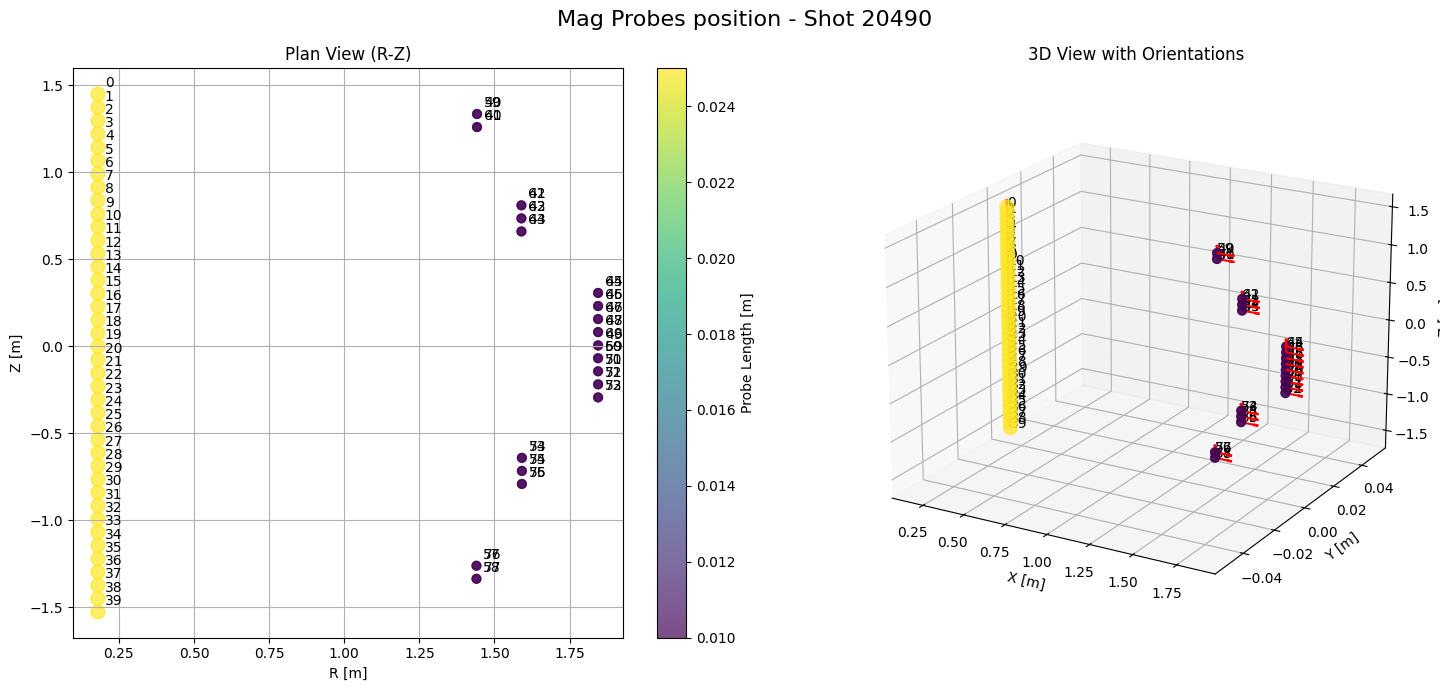

In [8]:
efm_data = shotloader.load(selected_shots[0], "efm")
plot_magnetic_probes(efm_data, selected_shots[0])

### B. Presence of variable fwtmp ?

In [9]:
import pandas as pd
import tqdm
from concurrent.futures import as_completed, ThreadPoolExecutor
from functools import partial

import os
import time
import psutil

In [10]:
def to_dask(shot: int, group: str = "efm", level: int = 1) -> xr.Dataset:
    """
    Return a Dataset from the MAST Zarr store.

    Parameters
    shot: Shot ID to retrieve data for.
    group: Diagnostic group to retrieve data from (default is "efm").
    level: Data level to retrieve (default is 1).
    """
    return xr.open_zarr(
        f"https://s3.echo.stfc.ac.uk/mast/level{level}/shots/{shot}.zarr",
        group=group,
    )

In [11]:
def retry_to_dask(shot_id, group, level, retries=5, delay=0.5, verbose=True):
    """
    Retry loading a shot's data as a Dask Dataset with exponential backoff.

    Parameters
    shot_id: Shot ID to retrieve data for.
    group: Diagnostic group to retrieve data from.
    level: Level of data to retrieve.
    retries: Number of retry attempts (default is 3).
    delay: Delay in seconds between retries (default is 5).

    Returns
    xr.Dataset
        The Dask Dataset for the specified shot and group.
    or Error
    """
    for attempt in range(retries):
        try:
            return to_dask(shot_id, group, level)
        except Exception as e:
            if attempt < retries - 1:
                if verbose:
                    print(f"Retrying connection to {shot_id} in group {group} (attempt {attempt + 1}/{retries})")
                time.sleep(delay)
            else:
                raise e

In [12]:
def process_shot(shot_id, verbose=False):
    """
    Process a single shot, returning a dictionary of results.

    Parameters
    shot_id: Shot ID to retrieve data for.
    verbose: bool
        Displays messages for debugging or tracking.
    
    Returns
    shot_id: int
        The shot ID processed.
    shot_result: dict
        Dictionary containing the presence of variables and their channels:
    """
    try:
        efm = retry_to_dask(shot_id, group="efm", level=1, verbose=verbose)
        try:
            fwtmp = efm.fwtmp.values
            if np.all(np.isnan(fwtmp)):
                code = 11
            elif np.any(np.isnan(fwtmp)):
                code = 12
            else:
                aggerated = np.mean(fwtmp, axis=1)
                ratio = np.sum(aggerated == 1.0) / len(aggerated)
                if ratio < 0.2:
                    code = 21
                elif ratio < 0.8 and ratio >= 0.2:
                    code = 22
                else:
                    code = 23
        except AttributeError:
            if verbose:
                print(f"No fwtmp data for shot {shot_id}")
            code = 0
            fwtmp = None
    except Exception as e:
        if verbose:
            print(f"Error loading efm data for shot {shot_id}: {e}")
        code = 0
        fwtmp = None
        
    result = {
        "shot_id": shot_id,
        "code": code,
        "fwtmp": fwtmp
    }
    if verbose:
        print(f"Processed shot {shot_id} with code {code}")
    return result



In [13]:
def get_optimal_workers(task_type="cpu"):
    """
    Get the optimal number of workers for parallel processing based on the task type.

    Parameters
    task_type: str
        Type of task to determine the optimal number of workers (possible: "cpu", or "gpu").

    Returns the optimal number of workers based on the task type.
    """
    cpu_logical = os.cpu_count()
    
    if task_type == "gpu":
        try:
            import torch
            if torch.cuda.is_available():
                return torch.cuda.device_count()
            else:
                return 0
        except ImportError:
            return 0
    elif task_type == "cpu":
        try:
            return psutil.cpu_count(logical=False)
        except:
            return max(1, cpu_logical // 2)  # Default to half of logical cores
    else:
        return max(1, cpu_logical - 1) # Default to one less than logical cores
    

In [14]:
def efit_analysis_parallel(
    shots: list[int],
    verbose: bool = False,
    max_workers: int = None,
    task_type: str = "cpu"
) -> pd.DataFrame:
    
    """
    Parallelized version with ThreadPoolExecutor.
    Check presence of all variables (and their channels) across shots in a group.

    Parameters
    shots: list of int
        List of shot IDs to be processed.
    verbose: bool
        Displays messages for debugging or tracking.
    max_workers: int, optional
        Maximum number of workers to use for parallel processing. If None, uses an optimal value based on get_optimal_worker.
    """
    if max_workers is None:
        max_workers = get_optimal_workers(task_type=task_type)
    print(f"Use of {max_workers} workers (type: {task_type})")

    data_efit = {}
    seen_shots = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for shot_id in shots:
            futures.append(executor.submit(partial(process_shot, verbose=verbose), shot_id))
        
        for future in tqdm.tqdm(
            as_completed(futures),
            total=len(shots),
            desc="Checking variables (parallel)"
        ):
            shot_result = future.result()
            seen_shots.append(shot_result["shot_id"])

            data_efit[shot_result["shot_id"]] = shot_result["code"]

    df = pd.DataFrame.from_dict(data_efit, orient="index", columns=["code"])
    df = df.reindex(sorted(df.columns), axis=1)
    return df

In [15]:
variable_presence_all = efit_analysis_parallel(
    shots=shot_list, 
    verbose=False,
    max_workers=None,
    task_type="cpu"
)

Use of 16 workers (type: cpu)


Checking variables (parallel): 100%|██████████| 11573/11573 [48:05<00:00,  4.01it/s] 


In [21]:
variable_presence_all[variable_presence_all['code'] == 21]

,code
11876,21
12034,21
12127,21
12128,21
12063,21
...,...
30470,21
30469,21
30467,21
30468,21


In [22]:
path = Path().absolute().parent / "result_files/efit_analysis" / "efit_analysis.csv"
path.parent.mkdir(parents=True, exist_ok=True)
variable_presence_all.to_csv(path)

In [ ]:
def process_shot(shot_id: int, output_dir: str):
    """
    Code: variable that show the status of the fwtmp
        0 = no data at all (no fwtmp)
        1 = fwtmp data exists but is all NaN
        2 = fwtmp data exists but is not valid (some NaN)
        3 = fwtmp data exists and is valid (not all NaN)
    """
    shotloader = ShotLoader()
    try:
        efm = shotloader.load(shot_id, "efm")
    except Exception as e:
        print(f"Error loading efm data for shot {shot_id}: {e}")
        code = 0
        return shot_id, code

    try:
        fwtmp = efm.fwtmp
        if np.all(np.isnan(fwtmp)):
            code = 1
        elif np.any(np.isnan(fwtmp)):
            code = 2
        else:
            code = 3
    except AttributeError:
        print(f"No fwtmp data for shot {shot_id}")
        code = 0
        fwtmp = None
        return shot_id, code

    try:
        summary = shotloader.load(shot_id, "summary")
        ip = summary.ip
    except Exception as e:
        print(f"Error loading summary data for shot {shot_id}: {e}")
        ip = None
        

    result = {
        "shot_id": shot_id,
        "code": code,
        "fwtmp": fwtmp,
        "ip": ip
    }    
    return result

In [ ]:
def process_all_shots(shot_list, output_dir, n_jobs=2):
    tasks = (delayed(process_shot)(shot_id, output_dir) for shot_id in shot_list)
    results = Parallel(n_jobs=n_jobs, verbose=11)(tasks)
    
    # Créer une DataFrame à partir des résultats
    df = pd.DataFrame(results)
    
    # Sauvegarder la DataFrame complète
    df_file = Path(output_dir) / "all_shots_results.csv"
    df.to_csv(df_file, index=False)
    
    # Afficher un résumé
    print(f"Traitement terminé. Résultats sauvegardés dans {df_file}")
    print(f"Répartition des codes:")
    print(df['code'].value_counts())
    
    return df

In [ ]:
output_dir = Path().absolute().parent / "result_files/efit_analysis/efit_parquet"
output_dir.mkdir(exist_ok=True, parents=True)
n_jobs = 1

results_df = process_all_shots(shot_list, output_dir, n_jobs)

### C. Data analysis for fwtmp